In this project, we will work with the medical mnist datasource, specifically the pneumonia dataset from https://medmnist.com/ . The problem consists of classifying chest x-ray images as having pneumonia or not. Run the below lines of code to install the appropriate dataloaders and visualize the data

In [ ]:
!pip install -qqq medmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

*** Challenge 1***

Here the goal is to train on 10 samples on the pneumonia mnist data. In this preliminary testbed, the evaluation will be done on a 1000 sample randomly sampled development set. Note in the end the final evaluation will be done on the full Pneumoniamnist test set as well as potentially a separate dataset. The development set samples here thus should not be used for training in any way, the final evaluation will provide only 10 random samples of the same distribution and as well to evaluate the generality of your algorithm from a data source that is not the Pneumoniamnist training data. 

Feel free to modify this testbed to your liking, including the normalization transformations, etc. Note, however, the final evaluation testbed will have a rigid set of components where you will need to place your answer. The only constraint is the data. Refer to the full project instructions for more information.


Below we set up training functions. Again you are free to fully modify this testbed in your prototyping within the constraints of the data used. You can use tools outside of PyTorch for training models if desired as well although the torchvision dataloaders will still be useful for interacting with the Pneumoniamnist dataset. 

In [ ]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

The below tries 5 random problem instances. Due to the small sample size, the variance of this problem is quite high. Run several instances of the problem to reduce the variance.

Resnet18 + RandAugment + HyperTuned parameters

In [ ]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    resNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

In [ ]:
%%time
from torchvision.transforms.autoaugment import RandAugment

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

trn_transform = transforms.Compose([transforms.RandAugment(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

val_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=trn_transform, download=download)
val_dataset = DataClass(split='train', transform=val_transform, download=download)

accs_val = []

for seed in  range(0, 50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128, 
                                             shuffle=False)

  model = resNet18()
  model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

  for epoch in range(250):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f (var: %.2f)'%(data_flag, accs_val.mean(), accs_val.std(), accs_val.var()))

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.774668
Train Epoch: 5 [0/10 (0%)]	Loss: 0.931402
Train Epoch: 10 [0/10 (0%)]	Loss: 0.911549
Train Epoch: 15 [0/10 (0%)]	Loss: 0.236429
Train Epoch: 20 [0/10 (0%)]	Loss: 0.049588
Train Epoch: 25 [0/10 (0%)]	Loss: 0.245473
Train Epoch: 30 [0/10 (0%)]	Loss: 0.294990
Train Epoch: 35 [0/10 (0%)]	Loss: 0.024950
Train Epoch: 40 [0/10 (0%)]	Loss: 0.257257
Train Epoch: 45 [0/10 (0%)]	Loss: 0.377826
Train Epoch: 50 [0/10 (0%)]	Loss: 0.043426
Train Epoch: 55 [0/10 (0%)]	Loss: 0.023594
Train Epoch: 60 [0/10 (0%)]	Loss: 0.236810
Train Epoch: 65 [0/10 (0%)]	Loss: 0.005120
Train Epoch: 70 [0/10 (0%)]	Loss: 0.033635
Train Epoch: 75 [0/10 (0%)]	Loss: 0.014350
Train Epoch: 80 [0/10 (0%)]	Loss: 0.001405
Train Epoch: 85 [0/10 (0%)]	Loss: 0.006527
Train Epoch: 90 [0/10 (0%)]	Loss: 0.019345
Train Epoch: 95 [0/10 (0%)]	Loss: 0.004502
Train Epoch: 100 [0/10 (0%)]	Loss: 0.000939
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001907
Train Epoch: 110 [0/10 (0%)]	Loss: 0.062906
Train Epoc

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 0.6347, Accuracy: 882/1000 (88.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.744719
Train Epoch: 5 [0/10 (0%)]	Loss: 1.013712
Train Epoch: 10 [0/10 (0%)]	Loss: 0.033251
Train Epoch: 15 [0/10 (0%)]	Loss: 0.020673
Train Epoch: 20 [0/10 (0%)]	Loss: 0.679689
Train Epoch: 25 [0/10 (0%)]	Loss: 0.155098
Train Epoch: 30 [0/10 (0%)]	Loss: 0.053741
Train Epoch: 35 [0/10 (0%)]	Loss: 0.022095
Train Epoch: 40 [0/10 (0%)]	Loss: 0.019421
Train Epoch: 45 [0/10 (0%)]	Loss: 0.006755
Train Epoch: 50 [0/10 (0%)]	Loss: 0.050243
Train Epoch: 55 [0/10 (0%)]	Loss: 0.080844
Train Epoch: 60 [0/10 (0%)]	Loss: 0.002910
Train Epoch: 65 [0/10 (0%)]	Loss: 0.004638
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002854
Train Epoch: 75 [0/10 (0%)]	Loss: 0.006914
Train Epoch: 80 [0/10 (0%)]	Loss: 0.145504
Train Epoch: 85 [0/10 (0%)]	Loss: 0.130514
Train Epoch: 90 [0/10 (0%)]	Loss: 0.365209
Train Epoch: 95 [0/10 (0%)]	Loss: 0.183683
Train Epoch: 100 [0/10 (0%)]	Loss: 0.093437
Train Epoch: 105 [0/10 (0%)]	Loss: 0.706783
Train Epoch: 110 [0/10 (0%)]	Loss: 0.640449
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.726710
Train Epoch: 5 [0/10 (0%)]	Loss: 0.476456
Train Epoch: 10 [0/10 (0%)]	Loss: 0.429056
Train Epoch: 15 [0/10 (0%)]	Loss: 0.033642
Train Epoch: 20 [0/10 (0%)]	Loss: 0.179719
Train Epoch: 25 [0/10 (0%)]	Loss: 0.073637
Train Epoch: 30 [0/10 (0%)]	Loss: 0.161582
Train Epoch: 35 [0/10 (0%)]	Loss: 0.137687
Train Epoch: 40 [0/10 (0%)]	Loss: 0.186097
Train Epoch: 45 [0/10 (0%)]	Loss: 0.201723
Train Epoch: 50 [0/10 (0%)]	Loss: 0.070122
Train Epoch: 55 [0/10 (0%)]	Loss: 0.126751
Train Epoch: 60 [0/10 (0%)]	Loss: 0.021930
Train Epoch: 65 [0/10 (0%)]	Loss: 0.011751
Train Epoch: 70 [0/10 (0%)]	Loss: 0.009082
Train Epoch: 75 [0/10 (0%)]	Loss: 0.006870
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002985
Train Epoch: 85 [0/10 (0%)]	Loss: 0.112904
Train Epoch: 90 [0/10 (0%)]	Loss: 0.411014
Train Epoch: 95 [0/10 (0%)]	Loss: 0.458156
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005942
Train Epoch: 105 [0/10 (0%)]	Loss: 0.004443
Train Epoch: 110 [0/10 (0%)]	Loss: 0.027178
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.760749
Train Epoch: 5 [0/10 (0%)]	Loss: 0.939153
Train Epoch: 10 [0/10 (0%)]	Loss: 0.850919
Train Epoch: 15 [0/10 (0%)]	Loss: 0.308572
Train Epoch: 20 [0/10 (0%)]	Loss: 0.605946
Train Epoch: 25 [0/10 (0%)]	Loss: 0.600263
Train Epoch: 30 [0/10 (0%)]	Loss: 0.228045
Train Epoch: 35 [0/10 (0%)]	Loss: 0.043828
Train Epoch: 40 [0/10 (0%)]	Loss: 0.368898
Train Epoch: 45 [0/10 (0%)]	Loss: 0.008218
Train Epoch: 50 [0/10 (0%)]	Loss: 0.064060
Train Epoch: 55 [0/10 (0%)]	Loss: 0.728526
Train Epoch: 60 [0/10 (0%)]	Loss: 0.035501
Train Epoch: 65 [0/10 (0%)]	Loss: 0.036862
Train Epoch: 70 [0/10 (0%)]	Loss: 0.094301
Train Epoch: 75 [0/10 (0%)]	Loss: 0.055623
Train Epoch: 80 [0/10 (0%)]	Loss: 0.273922
Train Epoch: 85 [0/10 (0%)]	Loss: 0.131784
Train Epoch: 90 [0/10 (0%)]	Loss: 0.583001
Train Epoch: 95 [0/10 (0%)]	Loss: 0.591203
Train Epoch: 100 [0/10 (0%)]	Loss: 0.007876
Train Epoch: 105 [0/10 (0%)]	Loss: 0.180265
Train Epoch: 110 [0/10 (0%)]	Loss: 0.021270
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.596122
Train Epoch: 5 [0/10 (0%)]	Loss: 1.232873
Train Epoch: 10 [0/10 (0%)]	Loss: 0.289202
Train Epoch: 15 [0/10 (0%)]	Loss: 0.255076
Train Epoch: 20 [0/10 (0%)]	Loss: 0.347608
Train Epoch: 25 [0/10 (0%)]	Loss: 0.046471
Train Epoch: 30 [0/10 (0%)]	Loss: 0.009221
Train Epoch: 35 [0/10 (0%)]	Loss: 0.004621
Train Epoch: 40 [0/10 (0%)]	Loss: 0.019749
Train Epoch: 45 [0/10 (0%)]	Loss: 0.001281
Train Epoch: 50 [0/10 (0%)]	Loss: 0.233917
Train Epoch: 55 [0/10 (0%)]	Loss: 0.006212
Train Epoch: 60 [0/10 (0%)]	Loss: 0.000629
Train Epoch: 65 [0/10 (0%)]	Loss: 0.000443
Train Epoch: 70 [0/10 (0%)]	Loss: 0.073646
Train Epoch: 75 [0/10 (0%)]	Loss: 0.000905
Train Epoch: 80 [0/10 (0%)]	Loss: 0.001144
Train Epoch: 85 [0/10 (0%)]	Loss: 0.002564
Train Epoch: 90 [0/10 (0%)]	Loss: 0.000376
Train Epoch: 95 [0/10 (0%)]	Loss: 0.000785
Train Epoch: 100 [0/10 (0%)]	Loss: 0.000911
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003751
Train Epoch: 110 [0/10 (0%)]	Loss: 0.208873
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.497708
Train Epoch: 5 [0/10 (0%)]	Loss: 0.450587
Train Epoch: 10 [0/10 (0%)]	Loss: 0.075907
Train Epoch: 15 [0/10 (0%)]	Loss: 0.007289
Train Epoch: 20 [0/10 (0%)]	Loss: 0.934785
Train Epoch: 25 [0/10 (0%)]	Loss: 0.481005
Train Epoch: 30 [0/10 (0%)]	Loss: 0.385401
Train Epoch: 35 [0/10 (0%)]	Loss: 0.052025
Train Epoch: 40 [0/10 (0%)]	Loss: 0.408640
Train Epoch: 45 [0/10 (0%)]	Loss: 0.008333
Train Epoch: 50 [0/10 (0%)]	Loss: 0.243182
Train Epoch: 55 [0/10 (0%)]	Loss: 0.061574
Train Epoch: 60 [0/10 (0%)]	Loss: 0.017588
Train Epoch: 65 [0/10 (0%)]	Loss: 0.409158
Train Epoch: 70 [0/10 (0%)]	Loss: 0.011486
Train Epoch: 75 [0/10 (0%)]	Loss: 0.117556
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006441
Train Epoch: 85 [0/10 (0%)]	Loss: 0.006657
Train Epoch: 90 [0/10 (0%)]	Loss: 0.518241
Train Epoch: 95 [0/10 (0%)]	Loss: 0.008986
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005299
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003586
Train Epoch: 110 [0/10 (0%)]	Loss: 0.037092
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.895724
Train Epoch: 5 [0/10 (0%)]	Loss: 1.053601
Train Epoch: 10 [0/10 (0%)]	Loss: 0.257404
Train Epoch: 15 [0/10 (0%)]	Loss: 0.297346
Train Epoch: 20 [0/10 (0%)]	Loss: 0.205229
Train Epoch: 25 [0/10 (0%)]	Loss: 0.246908
Train Epoch: 30 [0/10 (0%)]	Loss: 0.240873
Train Epoch: 35 [0/10 (0%)]	Loss: 0.071534
Train Epoch: 40 [0/10 (0%)]	Loss: 0.090153
Train Epoch: 45 [0/10 (0%)]	Loss: 0.034018
Train Epoch: 50 [0/10 (0%)]	Loss: 0.348485
Train Epoch: 55 [0/10 (0%)]	Loss: 0.070431
Train Epoch: 60 [0/10 (0%)]	Loss: 0.004174
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006181
Train Epoch: 70 [0/10 (0%)]	Loss: 0.003038
Train Epoch: 75 [0/10 (0%)]	Loss: 0.351364
Train Epoch: 80 [0/10 (0%)]	Loss: 0.005835
Train Epoch: 85 [0/10 (0%)]	Loss: 0.027938
Train Epoch: 90 [0/10 (0%)]	Loss: 0.461066
Train Epoch: 95 [0/10 (0%)]	Loss: 0.010967
Train Epoch: 100 [0/10 (0%)]	Loss: 0.094570
Train Epoch: 105 [0/10 (0%)]	Loss: 0.022593
Train Epoch: 110 [0/10 (0%)]	Loss: 0.014991
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.759127
Train Epoch: 5 [0/10 (0%)]	Loss: 0.467792
Train Epoch: 10 [0/10 (0%)]	Loss: 0.933418
Train Epoch: 15 [0/10 (0%)]	Loss: 0.110037
Train Epoch: 20 [0/10 (0%)]	Loss: 0.353668
Train Epoch: 25 [0/10 (0%)]	Loss: 0.056859
Train Epoch: 30 [0/10 (0%)]	Loss: 0.078906
Train Epoch: 35 [0/10 (0%)]	Loss: 0.048960
Train Epoch: 40 [0/10 (0%)]	Loss: 0.776778
Train Epoch: 45 [0/10 (0%)]	Loss: 0.011451
Train Epoch: 50 [0/10 (0%)]	Loss: 0.031863
Train Epoch: 55 [0/10 (0%)]	Loss: 0.021781
Train Epoch: 60 [0/10 (0%)]	Loss: 0.003473
Train Epoch: 65 [0/10 (0%)]	Loss: 0.428560
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002458
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004324
Train Epoch: 80 [0/10 (0%)]	Loss: 0.004466
Train Epoch: 85 [0/10 (0%)]	Loss: 0.261858
Train Epoch: 90 [0/10 (0%)]	Loss: 0.014022
Train Epoch: 95 [0/10 (0%)]	Loss: 0.008735
Train Epoch: 100 [0/10 (0%)]	Loss: 0.032347
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003010
Train Epoch: 110 [0/10 (0%)]	Loss: 0.003515
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.792505
Train Epoch: 5 [0/10 (0%)]	Loss: 0.505225
Train Epoch: 10 [0/10 (0%)]	Loss: 0.300647
Train Epoch: 15 [0/10 (0%)]	Loss: 0.071868
Train Epoch: 20 [0/10 (0%)]	Loss: 0.102152
Train Epoch: 25 [0/10 (0%)]	Loss: 0.075675
Train Epoch: 30 [0/10 (0%)]	Loss: 0.101843
Train Epoch: 35 [0/10 (0%)]	Loss: 0.008796
Train Epoch: 40 [0/10 (0%)]	Loss: 0.072840
Train Epoch: 45 [0/10 (0%)]	Loss: 0.001576
Train Epoch: 50 [0/10 (0%)]	Loss: 0.006812
Train Epoch: 55 [0/10 (0%)]	Loss: 0.001363
Train Epoch: 60 [0/10 (0%)]	Loss: 0.010256
Train Epoch: 65 [0/10 (0%)]	Loss: 0.010647
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002283
Train Epoch: 75 [0/10 (0%)]	Loss: 0.007064
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002047
Train Epoch: 85 [0/10 (0%)]	Loss: 0.007172
Train Epoch: 90 [0/10 (0%)]	Loss: 0.000678
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003031
Train Epoch: 100 [0/10 (0%)]	Loss: 0.011955
Train Epoch: 105 [0/10 (0%)]	Loss: 0.000420
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001201
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.800890
Train Epoch: 5 [0/10 (0%)]	Loss: 0.134445
Train Epoch: 10 [0/10 (0%)]	Loss: 1.056234
Train Epoch: 15 [0/10 (0%)]	Loss: 0.151333
Train Epoch: 20 [0/10 (0%)]	Loss: 0.306297
Train Epoch: 25 [0/10 (0%)]	Loss: 0.030272
Train Epoch: 30 [0/10 (0%)]	Loss: 0.162573
Train Epoch: 35 [0/10 (0%)]	Loss: 0.037440
Train Epoch: 40 [0/10 (0%)]	Loss: 0.125504
Train Epoch: 45 [0/10 (0%)]	Loss: 0.017259
Train Epoch: 50 [0/10 (0%)]	Loss: 0.750534
Train Epoch: 55 [0/10 (0%)]	Loss: 0.017669
Train Epoch: 60 [0/10 (0%)]	Loss: 0.003882
Train Epoch: 65 [0/10 (0%)]	Loss: 0.153301
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002358
Train Epoch: 75 [0/10 (0%)]	Loss: 0.014628
Train Epoch: 80 [0/10 (0%)]	Loss: 0.012546
Train Epoch: 85 [0/10 (0%)]	Loss: 0.008081
Train Epoch: 90 [0/10 (0%)]	Loss: 0.023980
Train Epoch: 95 [0/10 (0%)]	Loss: 0.005233
Train Epoch: 100 [0/10 (0%)]	Loss: 0.014699
Train Epoch: 105 [0/10 (0%)]	Loss: 0.006111
Train Epoch: 110 [0/10 (0%)]	Loss: 0.011451
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.845764
Train Epoch: 5 [0/10 (0%)]	Loss: 0.667074
Train Epoch: 10 [0/10 (0%)]	Loss: 0.041474
Train Epoch: 15 [0/10 (0%)]	Loss: 0.559671
Train Epoch: 20 [0/10 (0%)]	Loss: 0.167414
Train Epoch: 25 [0/10 (0%)]	Loss: 0.176986
Train Epoch: 30 [0/10 (0%)]	Loss: 0.019923
Train Epoch: 35 [0/10 (0%)]	Loss: 0.083905
Train Epoch: 40 [0/10 (0%)]	Loss: 0.003524
Train Epoch: 45 [0/10 (0%)]	Loss: 0.278031
Train Epoch: 50 [0/10 (0%)]	Loss: 0.014478
Train Epoch: 55 [0/10 (0%)]	Loss: 0.010321
Train Epoch: 60 [0/10 (0%)]	Loss: 0.040768
Train Epoch: 65 [0/10 (0%)]	Loss: 0.065701
Train Epoch: 70 [0/10 (0%)]	Loss: 0.013669
Train Epoch: 75 [0/10 (0%)]	Loss: 0.002897
Train Epoch: 80 [0/10 (0%)]	Loss: 0.001633
Train Epoch: 85 [0/10 (0%)]	Loss: 0.004066
Train Epoch: 90 [0/10 (0%)]	Loss: 0.029366
Train Epoch: 95 [0/10 (0%)]	Loss: 0.000712
Train Epoch: 100 [0/10 (0%)]	Loss: 0.000935
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002286
Train Epoch: 110 [0/10 (0%)]	Loss: 0.002374
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.870262
Train Epoch: 5 [0/10 (0%)]	Loss: 0.503684
Train Epoch: 10 [0/10 (0%)]	Loss: 0.139294
Train Epoch: 15 [0/10 (0%)]	Loss: 0.032416
Train Epoch: 20 [0/10 (0%)]	Loss: 0.007797
Train Epoch: 25 [0/10 (0%)]	Loss: 0.240448
Train Epoch: 30 [0/10 (0%)]	Loss: 0.206340
Train Epoch: 35 [0/10 (0%)]	Loss: 0.103929
Train Epoch: 40 [0/10 (0%)]	Loss: 0.016660
Train Epoch: 45 [0/10 (0%)]	Loss: 0.015397
Train Epoch: 50 [0/10 (0%)]	Loss: 0.049454
Train Epoch: 55 [0/10 (0%)]	Loss: 0.005178
Train Epoch: 60 [0/10 (0%)]	Loss: 0.023386
Train Epoch: 65 [0/10 (0%)]	Loss: 0.018836
Train Epoch: 70 [0/10 (0%)]	Loss: 0.046445
Train Epoch: 75 [0/10 (0%)]	Loss: 0.006726
Train Epoch: 80 [0/10 (0%)]	Loss: 0.003273
Train Epoch: 85 [0/10 (0%)]	Loss: 0.006157
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004752
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001219
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003593
Train Epoch: 105 [0/10 (0%)]	Loss: 0.005101
Train Epoch: 110 [0/10 (0%)]	Loss: 0.012156
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.777491
Train Epoch: 5 [0/10 (0%)]	Loss: 1.192462
Train Epoch: 10 [0/10 (0%)]	Loss: 0.427925
Train Epoch: 15 [0/10 (0%)]	Loss: 0.513977
Train Epoch: 20 [0/10 (0%)]	Loss: 0.509343
Train Epoch: 25 [0/10 (0%)]	Loss: 0.117658
Train Epoch: 30 [0/10 (0%)]	Loss: 0.042328
Train Epoch: 35 [0/10 (0%)]	Loss: 0.128108
Train Epoch: 40 [0/10 (0%)]	Loss: 0.027778
Train Epoch: 45 [0/10 (0%)]	Loss: 0.337388
Train Epoch: 50 [0/10 (0%)]	Loss: 0.027513
Train Epoch: 55 [0/10 (0%)]	Loss: 0.012647
Train Epoch: 60 [0/10 (0%)]	Loss: 0.146268
Train Epoch: 65 [0/10 (0%)]	Loss: 0.003554
Train Epoch: 70 [0/10 (0%)]	Loss: 0.003147
Train Epoch: 75 [0/10 (0%)]	Loss: 0.016796
Train Epoch: 80 [0/10 (0%)]	Loss: 0.030249
Train Epoch: 85 [0/10 (0%)]	Loss: 0.004453
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002386
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001590
Train Epoch: 100 [0/10 (0%)]	Loss: 0.008783
Train Epoch: 105 [0/10 (0%)]	Loss: 0.005287
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001014
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.773533
Train Epoch: 5 [0/10 (0%)]	Loss: 0.058292
Train Epoch: 10 [0/10 (0%)]	Loss: 0.331008
Train Epoch: 15 [0/10 (0%)]	Loss: 0.401935
Train Epoch: 20 [0/10 (0%)]	Loss: 0.660219
Train Epoch: 25 [0/10 (0%)]	Loss: 0.534113
Train Epoch: 30 [0/10 (0%)]	Loss: 0.290405
Train Epoch: 35 [0/10 (0%)]	Loss: 0.013296
Train Epoch: 40 [0/10 (0%)]	Loss: 0.060531
Train Epoch: 45 [0/10 (0%)]	Loss: 0.115201
Train Epoch: 50 [0/10 (0%)]	Loss: 0.004185
Train Epoch: 55 [0/10 (0%)]	Loss: 0.036801
Train Epoch: 60 [0/10 (0%)]	Loss: 0.004671
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006765
Train Epoch: 70 [0/10 (0%)]	Loss: 0.070609
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004983
Train Epoch: 80 [0/10 (0%)]	Loss: 0.129511
Train Epoch: 85 [0/10 (0%)]	Loss: 0.004594
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002756
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001308
Train Epoch: 100 [0/10 (0%)]	Loss: 0.001602
Train Epoch: 105 [0/10 (0%)]	Loss: 0.000525
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001013
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.681911
Train Epoch: 5 [0/10 (0%)]	Loss: 0.583705
Train Epoch: 10 [0/10 (0%)]	Loss: 0.081896
Train Epoch: 15 [0/10 (0%)]	Loss: 0.497718
Train Epoch: 20 [0/10 (0%)]	Loss: 0.228867
Train Epoch: 25 [0/10 (0%)]	Loss: 0.027501
Train Epoch: 30 [0/10 (0%)]	Loss: 0.027632
Train Epoch: 35 [0/10 (0%)]	Loss: 0.084123
Train Epoch: 40 [0/10 (0%)]	Loss: 0.006280
Train Epoch: 45 [0/10 (0%)]	Loss: 0.012667
Train Epoch: 50 [0/10 (0%)]	Loss: 0.052002
Train Epoch: 55 [0/10 (0%)]	Loss: 0.003718
Train Epoch: 60 [0/10 (0%)]	Loss: 0.052234
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006721
Train Epoch: 70 [0/10 (0%)]	Loss: 0.004122
Train Epoch: 75 [0/10 (0%)]	Loss: 0.003162
Train Epoch: 80 [0/10 (0%)]	Loss: 0.007605
Train Epoch: 85 [0/10 (0%)]	Loss: 0.010605
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005642
Train Epoch: 95 [0/10 (0%)]	Loss: 0.006201
Train Epoch: 100 [0/10 (0%)]	Loss: 0.004775
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003381
Train Epoch: 110 [0/10 (0%)]	Loss: 0.002096
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.880349
Train Epoch: 5 [0/10 (0%)]	Loss: 0.284434
Train Epoch: 10 [0/10 (0%)]	Loss: 0.324850
Train Epoch: 15 [0/10 (0%)]	Loss: 1.311747
Train Epoch: 20 [0/10 (0%)]	Loss: 0.786010
Train Epoch: 25 [0/10 (0%)]	Loss: 0.079007
Train Epoch: 30 [0/10 (0%)]	Loss: 0.057492
Train Epoch: 35 [0/10 (0%)]	Loss: 0.069075
Train Epoch: 40 [0/10 (0%)]	Loss: 0.051897
Train Epoch: 45 [0/10 (0%)]	Loss: 0.012684
Train Epoch: 50 [0/10 (0%)]	Loss: 0.051069
Train Epoch: 55 [0/10 (0%)]	Loss: 0.009687
Train Epoch: 60 [0/10 (0%)]	Loss: 0.127586
Train Epoch: 65 [0/10 (0%)]	Loss: 0.245769
Train Epoch: 70 [0/10 (0%)]	Loss: 0.101460
Train Epoch: 75 [0/10 (0%)]	Loss: 0.072473
Train Epoch: 80 [0/10 (0%)]	Loss: 0.134871
Train Epoch: 85 [0/10 (0%)]	Loss: 0.011504
Train Epoch: 90 [0/10 (0%)]	Loss: 0.006304
Train Epoch: 95 [0/10 (0%)]	Loss: 0.005628
Train Epoch: 100 [0/10 (0%)]	Loss: 0.004527
Train Epoch: 105 [0/10 (0%)]	Loss: 0.009799
Train Epoch: 110 [0/10 (0%)]	Loss: 0.058184
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.602360
Train Epoch: 5 [0/10 (0%)]	Loss: 0.699019
Train Epoch: 10 [0/10 (0%)]	Loss: 1.311712
Train Epoch: 15 [0/10 (0%)]	Loss: 0.668477
Train Epoch: 20 [0/10 (0%)]	Loss: 0.204635
Train Epoch: 25 [0/10 (0%)]	Loss: 0.253224
Train Epoch: 30 [0/10 (0%)]	Loss: 0.107884
Train Epoch: 35 [0/10 (0%)]	Loss: 0.135747
Train Epoch: 40 [0/10 (0%)]	Loss: 0.028992
Train Epoch: 45 [0/10 (0%)]	Loss: 0.245315
Train Epoch: 50 [0/10 (0%)]	Loss: 0.033015
Train Epoch: 55 [0/10 (0%)]	Loss: 0.002211
Train Epoch: 60 [0/10 (0%)]	Loss: 0.011008
Train Epoch: 65 [0/10 (0%)]	Loss: 0.072128
Train Epoch: 70 [0/10 (0%)]	Loss: 0.295508
Train Epoch: 75 [0/10 (0%)]	Loss: 0.121648
Train Epoch: 80 [0/10 (0%)]	Loss: 0.013741
Train Epoch: 85 [0/10 (0%)]	Loss: 0.054239
Train Epoch: 90 [0/10 (0%)]	Loss: 0.010768
Train Epoch: 95 [0/10 (0%)]	Loss: 0.732054
Train Epoch: 100 [0/10 (0%)]	Loss: 0.110839
Train Epoch: 105 [0/10 (0%)]	Loss: 0.004999
Train Epoch: 110 [0/10 (0%)]	Loss: 0.004446
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.707281
Train Epoch: 5 [0/10 (0%)]	Loss: 0.144742
Train Epoch: 10 [0/10 (0%)]	Loss: 0.888529
Train Epoch: 15 [0/10 (0%)]	Loss: 0.282904
Train Epoch: 20 [0/10 (0%)]	Loss: 0.035859
Train Epoch: 25 [0/10 (0%)]	Loss: 0.103557
Train Epoch: 30 [0/10 (0%)]	Loss: 0.562106
Train Epoch: 35 [0/10 (0%)]	Loss: 0.059589
Train Epoch: 40 [0/10 (0%)]	Loss: 0.237867
Train Epoch: 45 [0/10 (0%)]	Loss: 0.015177
Train Epoch: 50 [0/10 (0%)]	Loss: 0.396926
Train Epoch: 55 [0/10 (0%)]	Loss: 0.086631
Train Epoch: 60 [0/10 (0%)]	Loss: 0.024098
Train Epoch: 65 [0/10 (0%)]	Loss: 0.011563
Train Epoch: 70 [0/10 (0%)]	Loss: 0.050473
Train Epoch: 75 [0/10 (0%)]	Loss: 0.024779
Train Epoch: 80 [0/10 (0%)]	Loss: 0.043577
Train Epoch: 85 [0/10 (0%)]	Loss: 0.030628
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002719
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001717
Train Epoch: 100 [0/10 (0%)]	Loss: 0.002741
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001232
Train Epoch: 110 [0/10 (0%)]	Loss: 0.053862
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.720415
Train Epoch: 5 [0/10 (0%)]	Loss: 0.542791
Train Epoch: 10 [0/10 (0%)]	Loss: 0.023515
Train Epoch: 15 [0/10 (0%)]	Loss: 0.415969
Train Epoch: 20 [0/10 (0%)]	Loss: 0.255092
Train Epoch: 25 [0/10 (0%)]	Loss: 0.335076
Train Epoch: 30 [0/10 (0%)]	Loss: 0.078250
Train Epoch: 35 [0/10 (0%)]	Loss: 0.092909
Train Epoch: 40 [0/10 (0%)]	Loss: 0.045454
Train Epoch: 45 [0/10 (0%)]	Loss: 0.016101
Train Epoch: 50 [0/10 (0%)]	Loss: 0.656977
Train Epoch: 55 [0/10 (0%)]	Loss: 0.047758
Train Epoch: 60 [0/10 (0%)]	Loss: 0.016497
Train Epoch: 65 [0/10 (0%)]	Loss: 0.111006
Train Epoch: 70 [0/10 (0%)]	Loss: 0.007351
Train Epoch: 75 [0/10 (0%)]	Loss: 0.005693
Train Epoch: 80 [0/10 (0%)]	Loss: 0.012560
Train Epoch: 85 [0/10 (0%)]	Loss: 0.180220
Train Epoch: 90 [0/10 (0%)]	Loss: 0.008155
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003877
Train Epoch: 100 [0/10 (0%)]	Loss: 0.023154
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002748
Train Epoch: 110 [0/10 (0%)]	Loss: 0.002731
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.761226
Train Epoch: 5 [0/10 (0%)]	Loss: 0.196706
Train Epoch: 10 [0/10 (0%)]	Loss: 0.319949
Train Epoch: 15 [0/10 (0%)]	Loss: 0.143714
Train Epoch: 20 [0/10 (0%)]	Loss: 0.006493
Train Epoch: 25 [0/10 (0%)]	Loss: 0.001324
Train Epoch: 30 [0/10 (0%)]	Loss: 0.098258
Train Epoch: 35 [0/10 (0%)]	Loss: 0.897909
Train Epoch: 40 [0/10 (0%)]	Loss: 0.102506
Train Epoch: 45 [0/10 (0%)]	Loss: 0.416785
Train Epoch: 50 [0/10 (0%)]	Loss: 0.008215
Train Epoch: 55 [0/10 (0%)]	Loss: 0.089920
Train Epoch: 60 [0/10 (0%)]	Loss: 0.216656
Train Epoch: 65 [0/10 (0%)]	Loss: 0.042134
Train Epoch: 70 [0/10 (0%)]	Loss: 0.031072
Train Epoch: 75 [0/10 (0%)]	Loss: 0.011453
Train Epoch: 80 [0/10 (0%)]	Loss: 0.010323
Train Epoch: 85 [0/10 (0%)]	Loss: 0.004619
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002056
Train Epoch: 95 [0/10 (0%)]	Loss: 0.009842
Train Epoch: 100 [0/10 (0%)]	Loss: 0.001279
Train Epoch: 105 [0/10 (0%)]	Loss: 0.004430
Train Epoch: 110 [0/10 (0%)]	Loss: 0.007659
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.930698
Train Epoch: 5 [0/10 (0%)]	Loss: 1.195004
Train Epoch: 10 [0/10 (0%)]	Loss: 0.936051
Train Epoch: 15 [0/10 (0%)]	Loss: 0.260419
Train Epoch: 20 [0/10 (0%)]	Loss: 0.095416
Train Epoch: 25 [0/10 (0%)]	Loss: 0.011158
Train Epoch: 30 [0/10 (0%)]	Loss: 0.053188
Train Epoch: 35 [0/10 (0%)]	Loss: 0.012231
Train Epoch: 40 [0/10 (0%)]	Loss: 0.020607
Train Epoch: 45 [0/10 (0%)]	Loss: 0.007716
Train Epoch: 50 [0/10 (0%)]	Loss: 0.139800
Train Epoch: 55 [0/10 (0%)]	Loss: 0.022866
Train Epoch: 60 [0/10 (0%)]	Loss: 0.056769
Train Epoch: 65 [0/10 (0%)]	Loss: 0.001884
Train Epoch: 70 [0/10 (0%)]	Loss: 0.008852
Train Epoch: 75 [0/10 (0%)]	Loss: 0.009158
Train Epoch: 80 [0/10 (0%)]	Loss: 0.001496
Train Epoch: 85 [0/10 (0%)]	Loss: 0.031679
Train Epoch: 90 [0/10 (0%)]	Loss: 0.055169
Train Epoch: 95 [0/10 (0%)]	Loss: 0.024512
Train Epoch: 100 [0/10 (0%)]	Loss: 0.020590
Train Epoch: 105 [0/10 (0%)]	Loss: 0.114721
Train Epoch: 110 [0/10 (0%)]	Loss: 0.268699
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.814248
Train Epoch: 5 [0/10 (0%)]	Loss: 1.194494
Train Epoch: 10 [0/10 (0%)]	Loss: 0.348715
Train Epoch: 15 [0/10 (0%)]	Loss: 0.386263
Train Epoch: 20 [0/10 (0%)]	Loss: 0.380951
Train Epoch: 25 [0/10 (0%)]	Loss: 0.159283
Train Epoch: 30 [0/10 (0%)]	Loss: 0.335692
Train Epoch: 35 [0/10 (0%)]	Loss: 0.918276
Train Epoch: 40 [0/10 (0%)]	Loss: 0.852497
Train Epoch: 45 [0/10 (0%)]	Loss: 0.024402
Train Epoch: 50 [0/10 (0%)]	Loss: 0.254718
Train Epoch: 55 [0/10 (0%)]	Loss: 0.559079
Train Epoch: 60 [0/10 (0%)]	Loss: 0.087978
Train Epoch: 65 [0/10 (0%)]	Loss: 0.102356
Train Epoch: 70 [0/10 (0%)]	Loss: 0.247025
Train Epoch: 75 [0/10 (0%)]	Loss: 0.073712
Train Epoch: 80 [0/10 (0%)]	Loss: 0.016433
Train Epoch: 85 [0/10 (0%)]	Loss: 0.040401
Train Epoch: 90 [0/10 (0%)]	Loss: 0.296362
Train Epoch: 95 [0/10 (0%)]	Loss: 0.004656
Train Epoch: 100 [0/10 (0%)]	Loss: 0.013916
Train Epoch: 105 [0/10 (0%)]	Loss: 0.014443
Train Epoch: 110 [0/10 (0%)]	Loss: 0.023998
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.752571
Train Epoch: 5 [0/10 (0%)]	Loss: 0.116715
Train Epoch: 10 [0/10 (0%)]	Loss: 0.090357
Train Epoch: 15 [0/10 (0%)]	Loss: 0.103648
Train Epoch: 20 [0/10 (0%)]	Loss: 0.096578
Train Epoch: 25 [0/10 (0%)]	Loss: 0.289783
Train Epoch: 30 [0/10 (0%)]	Loss: 0.215224
Train Epoch: 35 [0/10 (0%)]	Loss: 0.176114
Train Epoch: 40 [0/10 (0%)]	Loss: 0.604531
Train Epoch: 45 [0/10 (0%)]	Loss: 0.009983
Train Epoch: 50 [0/10 (0%)]	Loss: 0.007927
Train Epoch: 55 [0/10 (0%)]	Loss: 0.024881
Train Epoch: 60 [0/10 (0%)]	Loss: 0.011894
Train Epoch: 65 [0/10 (0%)]	Loss: 0.022725
Train Epoch: 70 [0/10 (0%)]	Loss: 0.003402
Train Epoch: 75 [0/10 (0%)]	Loss: 0.000566
Train Epoch: 80 [0/10 (0%)]	Loss: 0.550954
Train Epoch: 85 [0/10 (0%)]	Loss: 0.000547
Train Epoch: 90 [0/10 (0%)]	Loss: 0.022403
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001307
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003191
Train Epoch: 105 [0/10 (0%)]	Loss: 0.014495
Train Epoch: 110 [0/10 (0%)]	Loss: 0.014279
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.753064
Train Epoch: 5 [0/10 (0%)]	Loss: 0.809860
Train Epoch: 10 [0/10 (0%)]	Loss: 0.212762
Train Epoch: 15 [0/10 (0%)]	Loss: 0.155360
Train Epoch: 20 [0/10 (0%)]	Loss: 0.101343
Train Epoch: 25 [0/10 (0%)]	Loss: 0.012312
Train Epoch: 30 [0/10 (0%)]	Loss: 0.255161
Train Epoch: 35 [0/10 (0%)]	Loss: 0.064930
Train Epoch: 40 [0/10 (0%)]	Loss: 0.040408
Train Epoch: 45 [0/10 (0%)]	Loss: 0.012371
Train Epoch: 50 [0/10 (0%)]	Loss: 0.300936
Train Epoch: 55 [0/10 (0%)]	Loss: 0.836252
Train Epoch: 60 [0/10 (0%)]	Loss: 0.050594
Train Epoch: 65 [0/10 (0%)]	Loss: 0.014978
Train Epoch: 70 [0/10 (0%)]	Loss: 0.056612
Train Epoch: 75 [0/10 (0%)]	Loss: 0.011657
Train Epoch: 80 [0/10 (0%)]	Loss: 0.008140
Train Epoch: 85 [0/10 (0%)]	Loss: 0.023129
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005749
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001725
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005514
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001834
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001811
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.624997
Train Epoch: 5 [0/10 (0%)]	Loss: 0.429474
Train Epoch: 10 [0/10 (0%)]	Loss: 0.174054
Train Epoch: 15 [0/10 (0%)]	Loss: 0.027144
Train Epoch: 20 [0/10 (0%)]	Loss: 0.033366
Train Epoch: 25 [0/10 (0%)]	Loss: 0.053780
Train Epoch: 30 [0/10 (0%)]	Loss: 0.794410
Train Epoch: 35 [0/10 (0%)]	Loss: 0.328161
Train Epoch: 40 [0/10 (0%)]	Loss: 0.175297
Train Epoch: 45 [0/10 (0%)]	Loss: 0.156232
Train Epoch: 50 [0/10 (0%)]	Loss: 0.016106
Train Epoch: 55 [0/10 (0%)]	Loss: 0.502814
Train Epoch: 60 [0/10 (0%)]	Loss: 0.006389
Train Epoch: 65 [0/10 (0%)]	Loss: 0.028688
Train Epoch: 70 [0/10 (0%)]	Loss: 0.112734
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004992
Train Epoch: 80 [0/10 (0%)]	Loss: 0.003487
Train Epoch: 85 [0/10 (0%)]	Loss: 0.023167
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002075
Train Epoch: 95 [0/10 (0%)]	Loss: 0.035333
Train Epoch: 100 [0/10 (0%)]	Loss: 0.364016
Train Epoch: 105 [0/10 (0%)]	Loss: 0.587835
Train Epoch: 110 [0/10 (0%)]	Loss: 0.021690
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.776250
Train Epoch: 5 [0/10 (0%)]	Loss: 0.619350
Train Epoch: 10 [0/10 (0%)]	Loss: 1.059327
Train Epoch: 15 [0/10 (0%)]	Loss: 1.071201
Train Epoch: 20 [0/10 (0%)]	Loss: 0.137431
Train Epoch: 25 [0/10 (0%)]	Loss: 0.123921
Train Epoch: 30 [0/10 (0%)]	Loss: 0.057810
Train Epoch: 35 [0/10 (0%)]	Loss: 0.046579
Train Epoch: 40 [0/10 (0%)]	Loss: 0.067115
Train Epoch: 45 [0/10 (0%)]	Loss: 0.248825
Train Epoch: 50 [0/10 (0%)]	Loss: 0.284813
Train Epoch: 55 [0/10 (0%)]	Loss: 0.047179
Train Epoch: 60 [0/10 (0%)]	Loss: 0.111620
Train Epoch: 65 [0/10 (0%)]	Loss: 0.083879
Train Epoch: 70 [0/10 (0%)]	Loss: 0.042494
Train Epoch: 75 [0/10 (0%)]	Loss: 0.006529
Train Epoch: 80 [0/10 (0%)]	Loss: 0.001492
Train Epoch: 85 [0/10 (0%)]	Loss: 0.007812
Train Epoch: 90 [0/10 (0%)]	Loss: 0.001729
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001950
Train Epoch: 100 [0/10 (0%)]	Loss: 0.050457
Train Epoch: 105 [0/10 (0%)]	Loss: 0.007861
Train Epoch: 110 [0/10 (0%)]	Loss: 0.003114
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.576577
Train Epoch: 5 [0/10 (0%)]	Loss: 0.377332
Train Epoch: 10 [0/10 (0%)]	Loss: 0.212394
Train Epoch: 15 [0/10 (0%)]	Loss: 0.183065
Train Epoch: 20 [0/10 (0%)]	Loss: 0.639026
Train Epoch: 25 [0/10 (0%)]	Loss: 0.024464
Train Epoch: 30 [0/10 (0%)]	Loss: 0.465177
Train Epoch: 35 [0/10 (0%)]	Loss: 0.444323
Train Epoch: 40 [0/10 (0%)]	Loss: 0.010821
Train Epoch: 45 [0/10 (0%)]	Loss: 0.037931
Train Epoch: 50 [0/10 (0%)]	Loss: 0.176436
Train Epoch: 55 [0/10 (0%)]	Loss: 0.890138
Train Epoch: 60 [0/10 (0%)]	Loss: 0.153999
Train Epoch: 65 [0/10 (0%)]	Loss: 0.001130
Train Epoch: 70 [0/10 (0%)]	Loss: 0.003746
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004308
Train Epoch: 80 [0/10 (0%)]	Loss: 0.060024
Train Epoch: 85 [0/10 (0%)]	Loss: 0.006109
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005928
Train Epoch: 95 [0/10 (0%)]	Loss: 0.002060
Train Epoch: 100 [0/10 (0%)]	Loss: 0.001801
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001967
Train Epoch: 110 [0/10 (0%)]	Loss: 0.181406
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.690025
Train Epoch: 5 [0/10 (0%)]	Loss: 0.487260
Train Epoch: 10 [0/10 (0%)]	Loss: 0.021106
Train Epoch: 15 [0/10 (0%)]	Loss: 0.274631
Train Epoch: 20 [0/10 (0%)]	Loss: 0.014695
Train Epoch: 25 [0/10 (0%)]	Loss: 0.005347
Train Epoch: 30 [0/10 (0%)]	Loss: 0.017942
Train Epoch: 35 [0/10 (0%)]	Loss: 0.813030
Train Epoch: 40 [0/10 (0%)]	Loss: 0.051245
Train Epoch: 45 [0/10 (0%)]	Loss: 0.045015
Train Epoch: 50 [0/10 (0%)]	Loss: 0.102937
Train Epoch: 55 [0/10 (0%)]	Loss: 0.126834
Train Epoch: 60 [0/10 (0%)]	Loss: 0.006999
Train Epoch: 65 [0/10 (0%)]	Loss: 0.015460
Train Epoch: 70 [0/10 (0%)]	Loss: 0.029266
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001056
Train Epoch: 80 [0/10 (0%)]	Loss: 0.031480
Train Epoch: 85 [0/10 (0%)]	Loss: 0.006189
Train Epoch: 90 [0/10 (0%)]	Loss: 0.028414
Train Epoch: 95 [0/10 (0%)]	Loss: 0.013590
Train Epoch: 100 [0/10 (0%)]	Loss: 0.512644
Train Epoch: 105 [0/10 (0%)]	Loss: 0.149995
Train Epoch: 110 [0/10 (0%)]	Loss: 0.025062
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.724481
Train Epoch: 5 [0/10 (0%)]	Loss: 1.818352
Train Epoch: 10 [0/10 (0%)]	Loss: 0.422574
Train Epoch: 15 [0/10 (0%)]	Loss: 0.114500
Train Epoch: 20 [0/10 (0%)]	Loss: 0.043704
Train Epoch: 25 [0/10 (0%)]	Loss: 0.818573
Train Epoch: 30 [0/10 (0%)]	Loss: 0.059084
Train Epoch: 35 [0/10 (0%)]	Loss: 0.024004
Train Epoch: 40 [0/10 (0%)]	Loss: 0.052845
Train Epoch: 45 [0/10 (0%)]	Loss: 0.035471
Train Epoch: 50 [0/10 (0%)]	Loss: 0.003026
Train Epoch: 55 [0/10 (0%)]	Loss: 0.003674
Train Epoch: 60 [0/10 (0%)]	Loss: 0.001929
Train Epoch: 65 [0/10 (0%)]	Loss: 0.213994
Train Epoch: 70 [0/10 (0%)]	Loss: 0.005227
Train Epoch: 75 [0/10 (0%)]	Loss: 0.187573
Train Epoch: 80 [0/10 (0%)]	Loss: 0.066835
Train Epoch: 85 [0/10 (0%)]	Loss: 0.008635
Train Epoch: 90 [0/10 (0%)]	Loss: 0.018400
Train Epoch: 95 [0/10 (0%)]	Loss: 0.015346
Train Epoch: 100 [0/10 (0%)]	Loss: 0.008964
Train Epoch: 105 [0/10 (0%)]	Loss: 0.016717
Train Epoch: 110 [0/10 (0%)]	Loss: 0.009996
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.665019
Train Epoch: 5 [0/10 (0%)]	Loss: 1.369770
Train Epoch: 10 [0/10 (0%)]	Loss: 1.352745
Train Epoch: 15 [0/10 (0%)]	Loss: 0.523129
Train Epoch: 20 [0/10 (0%)]	Loss: 0.339454
Train Epoch: 25 [0/10 (0%)]	Loss: 0.376054
Train Epoch: 30 [0/10 (0%)]	Loss: 0.782364
Train Epoch: 35 [0/10 (0%)]	Loss: 0.042621
Train Epoch: 40 [0/10 (0%)]	Loss: 0.326607
Train Epoch: 45 [0/10 (0%)]	Loss: 0.040335
Train Epoch: 50 [0/10 (0%)]	Loss: 0.132519
Train Epoch: 55 [0/10 (0%)]	Loss: 0.221617
Train Epoch: 60 [0/10 (0%)]	Loss: 0.062298
Train Epoch: 65 [0/10 (0%)]	Loss: 0.108635
Train Epoch: 70 [0/10 (0%)]	Loss: 0.050214
Train Epoch: 75 [0/10 (0%)]	Loss: 0.039836
Train Epoch: 80 [0/10 (0%)]	Loss: 0.174990
Train Epoch: 85 [0/10 (0%)]	Loss: 0.032938
Train Epoch: 90 [0/10 (0%)]	Loss: 0.018518
Train Epoch: 95 [0/10 (0%)]	Loss: 0.043531
Train Epoch: 100 [0/10 (0%)]	Loss: 0.019513
Train Epoch: 105 [0/10 (0%)]	Loss: 0.010581
Train Epoch: 110 [0/10 (0%)]	Loss: 0.005545
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.939402
Train Epoch: 5 [0/10 (0%)]	Loss: 0.827049
Train Epoch: 10 [0/10 (0%)]	Loss: 0.030272
Train Epoch: 15 [0/10 (0%)]	Loss: 0.004391
Train Epoch: 20 [0/10 (0%)]	Loss: 0.982334
Train Epoch: 25 [0/10 (0%)]	Loss: 0.029920
Train Epoch: 30 [0/10 (0%)]	Loss: 0.083449
Train Epoch: 35 [0/10 (0%)]	Loss: 0.027688
Train Epoch: 40 [0/10 (0%)]	Loss: 0.049687
Train Epoch: 45 [0/10 (0%)]	Loss: 0.100209
Train Epoch: 50 [0/10 (0%)]	Loss: 0.005477
Train Epoch: 55 [0/10 (0%)]	Loss: 0.044121
Train Epoch: 60 [0/10 (0%)]	Loss: 0.149301
Train Epoch: 65 [0/10 (0%)]	Loss: 0.003883
Train Epoch: 70 [0/10 (0%)]	Loss: 0.007037
Train Epoch: 75 [0/10 (0%)]	Loss: 0.000959
Train Epoch: 80 [0/10 (0%)]	Loss: 0.000698
Train Epoch: 85 [0/10 (0%)]	Loss: 0.000947
Train Epoch: 90 [0/10 (0%)]	Loss: 0.021430
Train Epoch: 95 [0/10 (0%)]	Loss: 0.008664
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003284
Train Epoch: 105 [0/10 (0%)]	Loss: 0.052619
Train Epoch: 110 [0/10 (0%)]	Loss: 0.454254
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.752288
Train Epoch: 5 [0/10 (0%)]	Loss: 0.077284
Train Epoch: 10 [0/10 (0%)]	Loss: 0.251076
Train Epoch: 15 [0/10 (0%)]	Loss: 0.647258
Train Epoch: 20 [0/10 (0%)]	Loss: 0.513901
Train Epoch: 25 [0/10 (0%)]	Loss: 0.117881
Train Epoch: 30 [0/10 (0%)]	Loss: 0.004870
Train Epoch: 35 [0/10 (0%)]	Loss: 0.017222
Train Epoch: 40 [0/10 (0%)]	Loss: 0.012619
Train Epoch: 45 [0/10 (0%)]	Loss: 0.010448
Train Epoch: 50 [0/10 (0%)]	Loss: 0.147626
Train Epoch: 55 [0/10 (0%)]	Loss: 0.032931
Train Epoch: 60 [0/10 (0%)]	Loss: 0.018708
Train Epoch: 65 [0/10 (0%)]	Loss: 0.043448
Train Epoch: 70 [0/10 (0%)]	Loss: 0.010894
Train Epoch: 75 [0/10 (0%)]	Loss: 0.011137
Train Epoch: 80 [0/10 (0%)]	Loss: 0.008771
Train Epoch: 85 [0/10 (0%)]	Loss: 0.085789
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005384
Train Epoch: 95 [0/10 (0%)]	Loss: 0.010378
Train Epoch: 100 [0/10 (0%)]	Loss: 0.223535
Train Epoch: 105 [0/10 (0%)]	Loss: 0.027349
Train Epoch: 110 [0/10 (0%)]	Loss: 0.003674
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.673364
Train Epoch: 5 [0/10 (0%)]	Loss: 0.389725
Train Epoch: 10 [0/10 (0%)]	Loss: 0.079868
Train Epoch: 15 [0/10 (0%)]	Loss: 0.452958
Train Epoch: 20 [0/10 (0%)]	Loss: 1.085847
Train Epoch: 25 [0/10 (0%)]	Loss: 0.176707
Train Epoch: 30 [0/10 (0%)]	Loss: 0.340548
Train Epoch: 35 [0/10 (0%)]	Loss: 0.064275
Train Epoch: 40 [0/10 (0%)]	Loss: 0.125021
Train Epoch: 45 [0/10 (0%)]	Loss: 0.052293
Train Epoch: 50 [0/10 (0%)]	Loss: 0.190247
Train Epoch: 55 [0/10 (0%)]	Loss: 0.397597
Train Epoch: 60 [0/10 (0%)]	Loss: 0.172127
Train Epoch: 65 [0/10 (0%)]	Loss: 0.250016
Train Epoch: 70 [0/10 (0%)]	Loss: 0.015923
Train Epoch: 75 [0/10 (0%)]	Loss: 0.377386
Train Epoch: 80 [0/10 (0%)]	Loss: 0.037789
Train Epoch: 85 [0/10 (0%)]	Loss: 0.092206
Train Epoch: 90 [0/10 (0%)]	Loss: 0.229941
Train Epoch: 95 [0/10 (0%)]	Loss: 0.024042
Train Epoch: 100 [0/10 (0%)]	Loss: 0.097879
Train Epoch: 105 [0/10 (0%)]	Loss: 0.040055
Train Epoch: 110 [0/10 (0%)]	Loss: 0.045105
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.780333
Train Epoch: 5 [0/10 (0%)]	Loss: 0.723997
Train Epoch: 10 [0/10 (0%)]	Loss: 0.735253
Train Epoch: 15 [0/10 (0%)]	Loss: 0.107769
Train Epoch: 20 [0/10 (0%)]	Loss: 1.021197
Train Epoch: 25 [0/10 (0%)]	Loss: 0.392127
Train Epoch: 30 [0/10 (0%)]	Loss: 0.042087
Train Epoch: 35 [0/10 (0%)]	Loss: 0.004501
Train Epoch: 40 [0/10 (0%)]	Loss: 0.218727
Train Epoch: 45 [0/10 (0%)]	Loss: 0.005242
Train Epoch: 50 [0/10 (0%)]	Loss: 0.070487
Train Epoch: 55 [0/10 (0%)]	Loss: 0.016467
Train Epoch: 60 [0/10 (0%)]	Loss: 0.121793
Train Epoch: 65 [0/10 (0%)]	Loss: 0.001941
Train Epoch: 70 [0/10 (0%)]	Loss: 0.044368
Train Epoch: 75 [0/10 (0%)]	Loss: 0.019750
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006537
Train Epoch: 85 [0/10 (0%)]	Loss: 0.001035
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004636
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001016
Train Epoch: 100 [0/10 (0%)]	Loss: 0.011519
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001293
Train Epoch: 110 [0/10 (0%)]	Loss: 0.035992
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.681551
Train Epoch: 5 [0/10 (0%)]	Loss: 0.339563
Train Epoch: 10 [0/10 (0%)]	Loss: 0.172958
Train Epoch: 15 [0/10 (0%)]	Loss: 0.036590
Train Epoch: 20 [0/10 (0%)]	Loss: 0.021580
Train Epoch: 25 [0/10 (0%)]	Loss: 0.355932
Train Epoch: 30 [0/10 (0%)]	Loss: 0.018783
Train Epoch: 35 [0/10 (0%)]	Loss: 0.027700
Train Epoch: 40 [0/10 (0%)]	Loss: 0.092738
Train Epoch: 45 [0/10 (0%)]	Loss: 0.044572
Train Epoch: 50 [0/10 (0%)]	Loss: 0.034184
Train Epoch: 55 [0/10 (0%)]	Loss: 0.010533
Train Epoch: 60 [0/10 (0%)]	Loss: 0.007283
Train Epoch: 65 [0/10 (0%)]	Loss: 0.016954
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002743
Train Epoch: 75 [0/10 (0%)]	Loss: 0.010032
Train Epoch: 80 [0/10 (0%)]	Loss: 0.001383
Train Epoch: 85 [0/10 (0%)]	Loss: 0.012935
Train Epoch: 90 [0/10 (0%)]	Loss: 0.000727
Train Epoch: 95 [0/10 (0%)]	Loss: 0.022728
Train Epoch: 100 [0/10 (0%)]	Loss: 0.767873
Train Epoch: 105 [0/10 (0%)]	Loss: 0.014935
Train Epoch: 110 [0/10 (0%)]	Loss: 0.009772
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.688536
Train Epoch: 5 [0/10 (0%)]	Loss: 0.686864
Train Epoch: 10 [0/10 (0%)]	Loss: 0.783898
Train Epoch: 15 [0/10 (0%)]	Loss: 0.203194
Train Epoch: 20 [0/10 (0%)]	Loss: 0.304146
Train Epoch: 25 [0/10 (0%)]	Loss: 0.242986
Train Epoch: 30 [0/10 (0%)]	Loss: 0.301189
Train Epoch: 35 [0/10 (0%)]	Loss: 0.073847
Train Epoch: 40 [0/10 (0%)]	Loss: 0.041204
Train Epoch: 45 [0/10 (0%)]	Loss: 0.023481
Train Epoch: 50 [0/10 (0%)]	Loss: 0.009679
Train Epoch: 55 [0/10 (0%)]	Loss: 0.133038
Train Epoch: 60 [0/10 (0%)]	Loss: 0.255824
Train Epoch: 65 [0/10 (0%)]	Loss: 0.607247
Train Epoch: 70 [0/10 (0%)]	Loss: 0.143448
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004744
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006373
Train Epoch: 85 [0/10 (0%)]	Loss: 0.011724
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004624
Train Epoch: 95 [0/10 (0%)]	Loss: 0.050172
Train Epoch: 100 [0/10 (0%)]	Loss: 0.006389
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002275
Train Epoch: 110 [0/10 (0%)]	Loss: 0.007935
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 1.002916
Train Epoch: 5 [0/10 (0%)]	Loss: 1.747788
Train Epoch: 10 [0/10 (0%)]	Loss: 0.362762
Train Epoch: 15 [0/10 (0%)]	Loss: 0.035329
Train Epoch: 20 [0/10 (0%)]	Loss: 0.164059
Train Epoch: 25 [0/10 (0%)]	Loss: 0.083583
Train Epoch: 30 [0/10 (0%)]	Loss: 0.413978
Train Epoch: 35 [0/10 (0%)]	Loss: 0.171864
Train Epoch: 40 [0/10 (0%)]	Loss: 0.016247
Train Epoch: 45 [0/10 (0%)]	Loss: 0.202413
Train Epoch: 50 [0/10 (0%)]	Loss: 0.008059
Train Epoch: 55 [0/10 (0%)]	Loss: 0.307833
Train Epoch: 60 [0/10 (0%)]	Loss: 0.026861
Train Epoch: 65 [0/10 (0%)]	Loss: 0.009159
Train Epoch: 70 [0/10 (0%)]	Loss: 0.092066
Train Epoch: 75 [0/10 (0%)]	Loss: 0.084863
Train Epoch: 80 [0/10 (0%)]	Loss: 0.009799
Train Epoch: 85 [0/10 (0%)]	Loss: 0.009669
Train Epoch: 90 [0/10 (0%)]	Loss: 0.017737
Train Epoch: 95 [0/10 (0%)]	Loss: 0.006171
Train Epoch: 100 [0/10 (0%)]	Loss: 0.006082
Train Epoch: 105 [0/10 (0%)]	Loss: 0.009255
Train Epoch: 110 [0/10 (0%)]	Loss: 0.008018
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.846022
Train Epoch: 5 [0/10 (0%)]	Loss: 1.200854
Train Epoch: 10 [0/10 (0%)]	Loss: 0.185700
Train Epoch: 15 [0/10 (0%)]	Loss: 0.067418
Train Epoch: 20 [0/10 (0%)]	Loss: 0.187941
Train Epoch: 25 [0/10 (0%)]	Loss: 0.578962
Train Epoch: 30 [0/10 (0%)]	Loss: 0.046755
Train Epoch: 35 [0/10 (0%)]	Loss: 0.189799
Train Epoch: 40 [0/10 (0%)]	Loss: 0.081520
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004441
Train Epoch: 50 [0/10 (0%)]	Loss: 0.025478
Train Epoch: 55 [0/10 (0%)]	Loss: 0.001366
Train Epoch: 60 [0/10 (0%)]	Loss: 0.177725
Train Epoch: 65 [0/10 (0%)]	Loss: 0.001026
Train Epoch: 70 [0/10 (0%)]	Loss: 0.261426
Train Epoch: 75 [0/10 (0%)]	Loss: 1.186591
Train Epoch: 80 [0/10 (0%)]	Loss: 0.023297
Train Epoch: 85 [0/10 (0%)]	Loss: 0.004533
Train Epoch: 90 [0/10 (0%)]	Loss: 0.037299
Train Epoch: 95 [0/10 (0%)]	Loss: 0.433280
Train Epoch: 100 [0/10 (0%)]	Loss: 0.018780
Train Epoch: 105 [0/10 (0%)]	Loss: 0.017824
Train Epoch: 110 [0/10 (0%)]	Loss: 0.013927
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.615605
Train Epoch: 5 [0/10 (0%)]	Loss: 0.254844
Train Epoch: 10 [0/10 (0%)]	Loss: 0.076610
Train Epoch: 15 [0/10 (0%)]	Loss: 0.148048
Train Epoch: 20 [0/10 (0%)]	Loss: 0.053810
Train Epoch: 25 [0/10 (0%)]	Loss: 0.049233
Train Epoch: 30 [0/10 (0%)]	Loss: 0.521099
Train Epoch: 35 [0/10 (0%)]	Loss: 0.036903
Train Epoch: 40 [0/10 (0%)]	Loss: 0.190251
Train Epoch: 45 [0/10 (0%)]	Loss: 0.002179
Train Epoch: 50 [0/10 (0%)]	Loss: 0.936533
Train Epoch: 55 [0/10 (0%)]	Loss: 0.258333
Train Epoch: 60 [0/10 (0%)]	Loss: 0.010589
Train Epoch: 65 [0/10 (0%)]	Loss: 0.015487
Train Epoch: 70 [0/10 (0%)]	Loss: 0.159085
Train Epoch: 75 [0/10 (0%)]	Loss: 0.025872
Train Epoch: 80 [0/10 (0%)]	Loss: 0.003285
Train Epoch: 85 [0/10 (0%)]	Loss: 0.000913
Train Epoch: 90 [0/10 (0%)]	Loss: 0.014570
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001430
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005553
Train Epoch: 105 [0/10 (0%)]	Loss: 0.000911
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001924
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.671833
Train Epoch: 5 [0/10 (0%)]	Loss: 0.236994
Train Epoch: 10 [0/10 (0%)]	Loss: 0.366992
Train Epoch: 15 [0/10 (0%)]	Loss: 0.013921
Train Epoch: 20 [0/10 (0%)]	Loss: 1.549243
Train Epoch: 25 [0/10 (0%)]	Loss: 0.369494
Train Epoch: 30 [0/10 (0%)]	Loss: 0.539819
Train Epoch: 35 [0/10 (0%)]	Loss: 0.462043
Train Epoch: 40 [0/10 (0%)]	Loss: 0.084861
Train Epoch: 45 [0/10 (0%)]	Loss: 0.091049
Train Epoch: 50 [0/10 (0%)]	Loss: 0.015486
Train Epoch: 55 [0/10 (0%)]	Loss: 0.023709
Train Epoch: 60 [0/10 (0%)]	Loss: 0.005701
Train Epoch: 65 [0/10 (0%)]	Loss: 0.060101
Train Epoch: 70 [0/10 (0%)]	Loss: 0.000835
Train Epoch: 75 [0/10 (0%)]	Loss: 0.003010
Train Epoch: 80 [0/10 (0%)]	Loss: 0.000839
Train Epoch: 85 [0/10 (0%)]	Loss: 0.001474
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002520
Train Epoch: 95 [0/10 (0%)]	Loss: 0.004804
Train Epoch: 100 [0/10 (0%)]	Loss: 0.526849
Train Epoch: 105 [0/10 (0%)]	Loss: 0.297712
Train Epoch: 110 [0/10 (0%)]	Loss: 0.150502
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.589479
Train Epoch: 5 [0/10 (0%)]	Loss: 0.269238
Train Epoch: 10 [0/10 (0%)]	Loss: 0.809006
Train Epoch: 15 [0/10 (0%)]	Loss: 1.552671
Train Epoch: 20 [0/10 (0%)]	Loss: 0.914967
Train Epoch: 25 [0/10 (0%)]	Loss: 0.365516
Train Epoch: 30 [0/10 (0%)]	Loss: 0.121677
Train Epoch: 35 [0/10 (0%)]	Loss: 0.014805
Train Epoch: 40 [0/10 (0%)]	Loss: 0.279293
Train Epoch: 45 [0/10 (0%)]	Loss: 0.302762
Train Epoch: 50 [0/10 (0%)]	Loss: 0.162976
Train Epoch: 55 [0/10 (0%)]	Loss: 0.066891
Train Epoch: 60 [0/10 (0%)]	Loss: 0.017706
Train Epoch: 65 [0/10 (0%)]	Loss: 0.045976
Train Epoch: 70 [0/10 (0%)]	Loss: 0.020718
Train Epoch: 75 [0/10 (0%)]	Loss: 0.005178
Train Epoch: 80 [0/10 (0%)]	Loss: 0.010336
Train Epoch: 85 [0/10 (0%)]	Loss: 0.002043
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004607
Train Epoch: 95 [0/10 (0%)]	Loss: 0.178884
Train Epoch: 100 [0/10 (0%)]	Loss: 0.001387
Train Epoch: 105 [0/10 (0%)]	Loss: 0.000740
Train Epoch: 110 [0/10 (0%)]	Loss: 0.134361
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.738605
Train Epoch: 5 [0/10 (0%)]	Loss: 0.676961
Train Epoch: 10 [0/10 (0%)]	Loss: 0.698060
Train Epoch: 15 [0/10 (0%)]	Loss: 0.509092
Train Epoch: 20 [0/10 (0%)]	Loss: 0.025240
Train Epoch: 25 [0/10 (0%)]	Loss: 0.212759
Train Epoch: 30 [0/10 (0%)]	Loss: 0.596517
Train Epoch: 35 [0/10 (0%)]	Loss: 0.268946
Train Epoch: 40 [0/10 (0%)]	Loss: 0.016599
Train Epoch: 45 [0/10 (0%)]	Loss: 0.015202
Train Epoch: 50 [0/10 (0%)]	Loss: 0.022594
Train Epoch: 55 [0/10 (0%)]	Loss: 0.026868
Train Epoch: 60 [0/10 (0%)]	Loss: 0.021708
Train Epoch: 65 [0/10 (0%)]	Loss: 0.097953
Train Epoch: 70 [0/10 (0%)]	Loss: 0.018274
Train Epoch: 75 [0/10 (0%)]	Loss: 0.014730
Train Epoch: 80 [0/10 (0%)]	Loss: 0.201440
Train Epoch: 85 [0/10 (0%)]	Loss: 0.051095
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002306
Train Epoch: 95 [0/10 (0%)]	Loss: 0.008245
Train Epoch: 100 [0/10 (0%)]	Loss: 0.001690
Train Epoch: 105 [0/10 (0%)]	Loss: 0.015967
Train Epoch: 110 [0/10 (0%)]	Loss: 0.129061
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.907440
Train Epoch: 5 [0/10 (0%)]	Loss: 1.173000
Train Epoch: 10 [0/10 (0%)]	Loss: 0.098168
Train Epoch: 15 [0/10 (0%)]	Loss: 0.184681
Train Epoch: 20 [0/10 (0%)]	Loss: 0.056868
Train Epoch: 25 [0/10 (0%)]	Loss: 0.287560
Train Epoch: 30 [0/10 (0%)]	Loss: 0.141089
Train Epoch: 35 [0/10 (0%)]	Loss: 0.073282
Train Epoch: 40 [0/10 (0%)]	Loss: 0.326104
Train Epoch: 45 [0/10 (0%)]	Loss: 0.425138
Train Epoch: 50 [0/10 (0%)]	Loss: 0.015071
Train Epoch: 55 [0/10 (0%)]	Loss: 0.050482
Train Epoch: 60 [0/10 (0%)]	Loss: 0.012325
Train Epoch: 65 [0/10 (0%)]	Loss: 0.016875
Train Epoch: 70 [0/10 (0%)]	Loss: 0.010090
Train Epoch: 75 [0/10 (0%)]	Loss: 0.002913
Train Epoch: 80 [0/10 (0%)]	Loss: 0.008316
Train Epoch: 85 [0/10 (0%)]	Loss: 0.010265
Train Epoch: 90 [0/10 (0%)]	Loss: 0.003427
Train Epoch: 95 [0/10 (0%)]	Loss: 0.004266
Train Epoch: 100 [0/10 (0%)]	Loss: 0.004595
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001829
Train Epoch: 110 [0/10 (0%)]	Loss: 0.003389
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.695599
Train Epoch: 5 [0/10 (0%)]	Loss: 1.367736
Train Epoch: 10 [0/10 (0%)]	Loss: 0.270921
Train Epoch: 15 [0/10 (0%)]	Loss: 0.381976
Train Epoch: 20 [0/10 (0%)]	Loss: 0.024221
Train Epoch: 25 [0/10 (0%)]	Loss: 0.007155
Train Epoch: 30 [0/10 (0%)]	Loss: 0.125357
Train Epoch: 35 [0/10 (0%)]	Loss: 0.059468
Train Epoch: 40 [0/10 (0%)]	Loss: 0.008239
Train Epoch: 45 [0/10 (0%)]	Loss: 0.017827
Train Epoch: 50 [0/10 (0%)]	Loss: 0.007787
Train Epoch: 55 [0/10 (0%)]	Loss: 0.001306
Train Epoch: 60 [0/10 (0%)]	Loss: 0.001901
Train Epoch: 65 [0/10 (0%)]	Loss: 0.045896
Train Epoch: 70 [0/10 (0%)]	Loss: 0.230382
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004972
Train Epoch: 80 [0/10 (0%)]	Loss: 0.031444
Train Epoch: 85 [0/10 (0%)]	Loss: 0.008275
Train Epoch: 90 [0/10 (0%)]	Loss: 0.014417
Train Epoch: 95 [0/10 (0%)]	Loss: 0.312263
Train Epoch: 100 [0/10 (0%)]	Loss: 0.002842
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001524
Train Epoch: 110 [0/10 (0%)]	Loss: 0.056066
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.898269
Train Epoch: 5 [0/10 (0%)]	Loss: 0.514537
Train Epoch: 10 [0/10 (0%)]	Loss: 0.158810
Train Epoch: 15 [0/10 (0%)]	Loss: 0.090963
Train Epoch: 20 [0/10 (0%)]	Loss: 0.173720
Train Epoch: 25 [0/10 (0%)]	Loss: 0.008032
Train Epoch: 30 [0/10 (0%)]	Loss: 0.010435
Train Epoch: 35 [0/10 (0%)]	Loss: 0.588972
Train Epoch: 40 [0/10 (0%)]	Loss: 0.140459
Train Epoch: 45 [0/10 (0%)]	Loss: 0.990311
Train Epoch: 50 [0/10 (0%)]	Loss: 0.023051
Train Epoch: 55 [0/10 (0%)]	Loss: 1.224295
Train Epoch: 60 [0/10 (0%)]	Loss: 0.142738
Train Epoch: 65 [0/10 (0%)]	Loss: 0.124854
Train Epoch: 70 [0/10 (0%)]	Loss: 0.102743
Train Epoch: 75 [0/10 (0%)]	Loss: 0.046382
Train Epoch: 80 [0/10 (0%)]	Loss: 0.007360
Train Epoch: 85 [0/10 (0%)]	Loss: 0.008197
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005201
Train Epoch: 95 [0/10 (0%)]	Loss: 0.053344
Train Epoch: 100 [0/10 (0%)]	Loss: 0.330599
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002587
Train Epoch: 110 [0/10 (0%)]	Loss: 0.005155
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.734657
Train Epoch: 5 [0/10 (0%)]	Loss: 0.235232
Train Epoch: 10 [0/10 (0%)]	Loss: 0.006757
Train Epoch: 15 [0/10 (0%)]	Loss: 0.087209
Train Epoch: 20 [0/10 (0%)]	Loss: 0.170763
Train Epoch: 25 [0/10 (0%)]	Loss: 0.003052
Train Epoch: 30 [0/10 (0%)]	Loss: 0.001311
Train Epoch: 35 [0/10 (0%)]	Loss: 0.023975
Train Epoch: 40 [0/10 (0%)]	Loss: 0.031974
Train Epoch: 45 [0/10 (0%)]	Loss: 0.603770
Train Epoch: 50 [0/10 (0%)]	Loss: 0.012216
Train Epoch: 55 [0/10 (0%)]	Loss: 0.020709
Train Epoch: 60 [0/10 (0%)]	Loss: 0.019517
Train Epoch: 65 [0/10 (0%)]	Loss: 0.585063
Train Epoch: 70 [0/10 (0%)]	Loss: 0.008046
Train Epoch: 75 [0/10 (0%)]	Loss: 0.016295
Train Epoch: 80 [0/10 (0%)]	Loss: 0.011949
Train Epoch: 85 [0/10 (0%)]	Loss: 0.015413
Train Epoch: 90 [0/10 (0%)]	Loss: 0.020376
Train Epoch: 95 [0/10 (0%)]	Loss: 0.002024
Train Epoch: 100 [0/10 (0%)]	Loss: 0.007185
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002039
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001493
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.797222
Train Epoch: 5 [0/10 (0%)]	Loss: 0.691574
Train Epoch: 10 [0/10 (0%)]	Loss: 0.727794
Train Epoch: 15 [0/10 (0%)]	Loss: 0.017417
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000519
Train Epoch: 25 [0/10 (0%)]	Loss: 0.381739
Train Epoch: 30 [0/10 (0%)]	Loss: 0.093751
Train Epoch: 35 [0/10 (0%)]	Loss: 0.011005
Train Epoch: 40 [0/10 (0%)]	Loss: 0.009134
Train Epoch: 45 [0/10 (0%)]	Loss: 0.140481
Train Epoch: 50 [0/10 (0%)]	Loss: 0.105109
Train Epoch: 55 [0/10 (0%)]	Loss: 0.002717
Train Epoch: 60 [0/10 (0%)]	Loss: 0.013108
Train Epoch: 65 [0/10 (0%)]	Loss: 0.025003
Train Epoch: 70 [0/10 (0%)]	Loss: 0.019927
Train Epoch: 75 [0/10 (0%)]	Loss: 0.003712
Train Epoch: 80 [0/10 (0%)]	Loss: 0.005798
Train Epoch: 85 [0/10 (0%)]	Loss: 0.002075
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004298
Train Epoch: 95 [0/10 (0%)]	Loss: 0.006054
Train Epoch: 100 [0/10 (0%)]	Loss: 0.006192
Train Epoch: 105 [0/10 (0%)]	Loss: 0.081841
Train Epoch: 110 [0/10 (0%)]	Loss: 0.033596
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.837362
Train Epoch: 5 [0/10 (0%)]	Loss: 0.277284
Train Epoch: 10 [0/10 (0%)]	Loss: 0.199176
Train Epoch: 15 [0/10 (0%)]	Loss: 0.267191
Train Epoch: 20 [0/10 (0%)]	Loss: 2.183206
Train Epoch: 25 [0/10 (0%)]	Loss: 0.253894
Train Epoch: 30 [0/10 (0%)]	Loss: 0.204907
Train Epoch: 35 [0/10 (0%)]	Loss: 0.058526
Train Epoch: 40 [0/10 (0%)]	Loss: 0.098155
Train Epoch: 45 [0/10 (0%)]	Loss: 0.066343
Train Epoch: 50 [0/10 (0%)]	Loss: 0.094753
Train Epoch: 55 [0/10 (0%)]	Loss: 0.013683
Train Epoch: 60 [0/10 (0%)]	Loss: 0.018047
Train Epoch: 65 [0/10 (0%)]	Loss: 0.107152
Train Epoch: 70 [0/10 (0%)]	Loss: 0.018875
Train Epoch: 75 [0/10 (0%)]	Loss: 0.456917
Train Epoch: 80 [0/10 (0%)]	Loss: 0.355202
Train Epoch: 85 [0/10 (0%)]	Loss: 0.051801
Train Epoch: 90 [0/10 (0%)]	Loss: 0.453529
Train Epoch: 95 [0/10 (0%)]	Loss: 0.079445
Train Epoch: 100 [0/10 (0%)]	Loss: 0.084158
Train Epoch: 105 [0/10 (0%)]	Loss: 0.013709
Train Epoch: 110 [0/10 (0%)]	Loss: 0.009375
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.732514
Train Epoch: 5 [0/10 (0%)]	Loss: 0.790966
Train Epoch: 10 [0/10 (0%)]	Loss: 0.134268
Train Epoch: 15 [0/10 (0%)]	Loss: 0.569002
Train Epoch: 20 [0/10 (0%)]	Loss: 0.823266
Train Epoch: 25 [0/10 (0%)]	Loss: 0.532642
Train Epoch: 30 [0/10 (0%)]	Loss: 0.034923
Train Epoch: 35 [0/10 (0%)]	Loss: 0.024831
Train Epoch: 40 [0/10 (0%)]	Loss: 0.358514
Train Epoch: 45 [0/10 (0%)]	Loss: 0.405628
Train Epoch: 50 [0/10 (0%)]	Loss: 0.037609
Train Epoch: 55 [0/10 (0%)]	Loss: 0.145702
Train Epoch: 60 [0/10 (0%)]	Loss: 0.057471
Train Epoch: 65 [0/10 (0%)]	Loss: 0.023169
Train Epoch: 70 [0/10 (0%)]	Loss: 0.012109
Train Epoch: 75 [0/10 (0%)]	Loss: 0.017037
Train Epoch: 80 [0/10 (0%)]	Loss: 0.011420
Train Epoch: 85 [0/10 (0%)]	Loss: 0.145515
Train Epoch: 90 [0/10 (0%)]	Loss: 0.026479
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001537
Train Epoch: 100 [0/10 (0%)]	Loss: 0.011981
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003093
Train Epoch: 110 [0/10 (0%)]	Loss: 0.008540
Train Epoc

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.915599
Train Epoch: 5 [0/10 (0%)]	Loss: 0.933789
Train Epoch: 10 [0/10 (0%)]	Loss: 0.031122
Train Epoch: 15 [0/10 (0%)]	Loss: 0.053472
Train Epoch: 20 [0/10 (0%)]	Loss: 0.573634
Train Epoch: 25 [0/10 (0%)]	Loss: 0.534968
Train Epoch: 30 [0/10 (0%)]	Loss: 0.535658
Train Epoch: 35 [0/10 (0%)]	Loss: 1.056762
Train Epoch: 40 [0/10 (0%)]	Loss: 0.046596
Train Epoch: 45 [0/10 (0%)]	Loss: 0.306901
Train Epoch: 50 [0/10 (0%)]	Loss: 0.046443
Train Epoch: 55 [0/10 (0%)]	Loss: 0.094440
Train Epoch: 60 [0/10 (0%)]	Loss: 0.035779
Train Epoch: 65 [0/10 (0%)]	Loss: 0.256941
Train Epoch: 70 [0/10 (0%)]	Loss: 0.150093
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004878
Train Epoch: 80 [0/10 (0%)]	Loss: 0.039987
Train Epoch: 85 [0/10 (0%)]	Loss: 0.035776
Train Epoch: 90 [0/10 (0%)]	Loss: 0.009192
Train Epoch: 95 [0/10 (0%)]	Loss: 0.017514
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003539
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002905
Train Epoch: 110 [0/10 (0%)]	Loss: 0.013699
Train Epoc

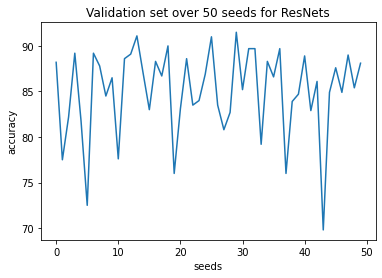

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('seeds')
plt.ylabel('accuracy')
plt.title('Validation set over 50 seeds for ResNets');
plt.savefig('C1val5seeds_bestmodel.png')